## predicting the health uninsured in the US

This project will call data from the American Community Survey Public Use MicroSample(PUMS) API. The most recent survey publicly availble at this API is from 2019. (Note data from 2020 are available to download in csv files).

This project uses the Census Bureau Data API but is not endorsed or certified by the Census Bureau.

1. American Community Survey (ACS) (census.gov).
https://www.census.gov/programs-surveys/acs/
2. American Community Survey Data via API (census.gov).
https://www.census.gov/programs-surveys/acs/data/data-via-api.html

The goal of this project is to predict whether an individual has health insurance (or not) based on demographic data in the PUMS. 

In [1]:
# import libraries
import os
import glob
import pandas as pd
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

There are hundreds of variables in the PUMS dataset. Load in the variable names (code) and their descriptions (label) from the API.

In [2]:
# load variable names from census PUMS (public use microsample) API
load_dotenv()
API_KEY  = os.getenv('CENSUS_API_KEY')
host     = 'https://api.census.gov/data'
year     = 2019
dataset  = 'acs/acs1/pums/variables'
base_url = "/".join([host, str(year), dataset]) 
r        = requests.get(base_url)
rlists   = r.json()
code     = [item[0] for item in rlists if item[0].isupper()] #code in API
label    = [item[1].lower() for item in rlists if item[0].isupper()] # description for each code
nsamples = 500

codedict = {} # redudant with code, label but may make life easier later on
count    = 0
for lab in label:
    codedict[code[count]] = lab
    count += 1

In [3]:
# this link leads to info on the codes for each state + DC which we need for our api calls
stateinfo = pd.read_csv('https://www2.census.gov/programs-surveys/acs/tech_docs/pums/top_coded_values/2019_pums_top_and_bottom_coded_values.csv')
stateinfo = stateinfo.loc[:, stateinfo.columns.isin(['BST','STATE'])]
print(stateinfo.tail())
# Drop Puerto Rico for simplicity
stateinfo = stateinfo[stateinfo.STATE != 'PR']
print(stateinfo.tail())

    BST STATE
47   53    WA
48   54    WV
49   55    WI
50   56    WY
51   72    PR
    BST STATE
46   51    VA
47   53    WA
48   54    WV
49   55    WI
50   56    WY


When calling the Census API, a maximum of 50 variables can be requested at one time. The data are also easily accessed state-by-state. The PUMS represents ~1% of the population. If we want to use data from all states, we could start by subsampling from availbable records. Set the number of samples (nsamples) in getCensusDataByState().

One approach is to request data from a list of variables for a specific state in one call. The function callCensusAPI() below is meant to return a dataframe with variables in 'select_codes' from one state ('stateid'). A second function, getCensusDataByState() is meant to request data for all variables for one state in multiple calls and merge that data into one single dataframe for that state.

In [4]:
# function to get data from Census API, Public Access MicroData Samples using list of codes (max 50), state id number 
def callCensusApi(API_KEY,year,select_codes,stateid):
    host     = 'https://api.census.gov/data'
    dataset  = 'acs/acs1/pums'
    query    = '?get='
    variable = ','.join(select_codes)
    base_url = "/".join([host, str(year), dataset]) + query + variable + '&for=state:' + stateid + '&key=' + API_KEY
    callbeg  = time.time()
    r        = requests.get(base_url) 
    colnames = variable.split(',')
    colnames.append('state')
    df       = pd.DataFrame(columns=colnames, data=r.json()[1:]) 
    tElapsed = time.time()-callbeg
    return (tElapsed,df)

In [5]:
# get full dataframe (all variables in code) for one state. uses callCensusAPI function above
def getCensusDataByState(state_id):
    max_var_call = 50
    start_var_n  = 0
    end_var_n = start_var_n + max_var_call
    totalTime = 0
    while end_var_n <= len(code): 
        tElapsed, hdf = callCensusApi(API_KEY,year,code[start_var_n:end_var_n],state_id)
        if start_var_n == 0:
            df = hdf.sample(nsamples)
            rowid = df.index
            df = df.reset_index()
        else:
            sub = hdf.iloc[rowid]
            sub = sub.reset_index()
            df = pd.merge(df,sub,how='left',on='index')
            del sub
        totalTime = totalTime + tElapsed
        start_var_n = end_var_n + 1
        end_var_n = start_var_n + max_var_call
    if df.shape[1] < len(code):
        tElapsed, hdf = callCensusApi(API_KEY,year,code[start_var_n:len(code)],state_id)
        sub = hdf.iloc[rowid]
        sub = sub.reset_index()
        df  = pd.merge(df,sub,how='left',on='index')      
        totalTime = totalTime + tElapsed
        del hdf
    return (df,totalTime)

With the functions above, we can loop through our states of interest and save a dataframe for each if it does not exist locally yet.

In [6]:
datadir = os.path.join(os.getcwd(),"data")
try:
    os.mkdir(datadir)
except:
    print('directory already exists')

directory already exists


In [7]:
# call API for states in loop and save csv locally if it doesn't exist yet:
for state in stateinfo['BST']:
    state_id  =  f"{state:02}"
    fname = os.path.join(datadir,'state' + state_id + '_subsample' + str(nsamples) + '.csv')
    if os.path.exists(fname) == False:
        df,totalTime = getCensusDataByState(state_id)
        # save the data to a new csv file
        df.to_csv(fname)
        print('state' + state_id + ': ' + str(totalTime))
        del df
        del fname
        del state_id

In [8]:
# load saved csv files:
filenames = glob.glob(os.path.join(datadir,'state' + '*' + str(nsamples) + '.csv'))
data_all = pd.concat((pd.read_csv(file) for file in filenames)).reset_index(drop = True) # Import

In [9]:
# check basic attributes of saved data:
print('shape of the subsampled dataframe: ' + str(data_all.shape[0]) + ' by ' + str(data_all.shape[1]))
print(data_all.head())

shape of the subsampled dataframe: 25500 by 518
   Unnamed: 0  index  HHLANP  FBATHP  DRIVESP  WGTP23  WGTP22  WGTP25  WGTP24  \
0           0  35900    9500       0        0     225      61     246      81   
1           1  13014    9500       0        0      48      55      42      16   
2           2  44316    9500       1        0      91     132      93     160   
3           3  26573    9500       0        0      60      77      53      57   
4           4  27452    9500       0        0      25      94     123      34   

   RACNH  ...  FDOUTP  PERNP  SCH  state_y.4  TEL  TEN  MLPI  MLPJ  MLPK  \
0      0  ...       0  29200    1          1    1    3    -1    -1    -1   
1      0  ...       0 -10001    2          1    1    1    -1    -1    -1   
2      0  ...       0   2600    2          1    1    3    -1    -1    -1   
3      0  ...       0      0    1          1    1    2    -1    -1    -1   
4      0  ...       0 -10001    3          1    1    3     0     0     0   

   state

In [10]:
# call api for more details on a specific variable
def variableDetails(codename):
    base_url = "/".join([host, str(year), dataset, codename + '.json']) 
    r        = requests.get(base_url)
    detail   = r.json()
    return detail

In [11]:
# check for extra columns that may have appeared from the dataframe merger:
for column in data_all:
    if column not in codedict.keys():
        if column.__contains__('.'):
            data_all.drop(column,axis=1,inplace=True)
        else:
            print('keeping ' + column)

print(data_all.shape)

keeping Unnamed: 0
keeping index
keeping state_x
keeping state_y
keeping state
(25500, 510)


In [12]:
# based on the way we merged state_x and state_y should be redundant
if data_all['state_x'].equals(data_all['state_y']):
    data_all.drop('state_y',inplace=True,axis=1)

In [13]:
# the state column should be incomplete based on the way we merged, drop if it has more missing values than 'state_x'
if data_all['state'].isna().sum() > data_all['state_x'].isna().sum():
    data_all.drop('state',axis=1,inplace=True)
# drop Unnamed: 0 because it's not useful at this point (from old indices)
data_all.drop('Unnamed: 0',axis=1,inplace=True)

In [14]:
# add state name from stateinfo to data_all for ease
data_all = data_all.merge(stateinfo,left_on='state_x',right_on='BST')

In [15]:
if data_all['state'].equals(data_all['BST']):
    data_all = data_all.drop('state',axis=1)

In [16]:
data_all[['state_x','STATE']].head()

,state_x,STATE
0,1,AL
1,1,AL
2,1,AL
3,1,AL
4,1,AL


Looks like we can just drop 'state_x' actually because the abbreviation should be good enough for us. 

In [17]:
data_all.drop(['state_x','BST','ST'],axis=1,inplace=True)

In [18]:
# check for target variable (health insured or not):
for key, value in codedict.items():
    if value.__contains__('health insurance'):
        print(key + " : " + value)

PRIVCOV : private health insurance coverage recode
HICOV : health insurance coverage recode
FHICOVP : health insurance coverage recode allocation flag
FPRIVCOVP : private health insurance coverage recode allocation flag


let's check details on health insurance coverage recode, and "...allocation flag"

In [19]:
codename = 'HICOV'
details = variableDetails(codename)
print('from ' + codename + ' : ')
for key,value in details['values']['item'].items():
    print(key, ':', value)

codename = 'FHICOVP'
print('from ' + codename + ' : ')
details = variableDetails(codename)
for key,value in details['values']['item'].items():
    print(key, ':', value)

from HICOV : 
2 : No health insurance coverage
1 : With health insurance coverage
from FHICOVP : 
0 : No
1 : Yes


In [20]:
# we can drop the HICOV column, since HICOV and FHICOVP have the same info
print(data_all.shape)
data_all.drop('HICOV',axis=1,inplace=True)
print(data_all.shape)

(25500, 506)
(25500, 505)


In [21]:
# what else can we drop? 
# check for variables with lots of -1 (+ check this means N/A):
missing_val = -1
thresh      = .33
for column in data_all:
    if any(data_all[column].isin([missing_val])):
        if data_all[column].isin([missing_val]).sum()/len(data_all[column]) > thresh:
            dets = variableDetails(column)
            if dets['values']['item']['-1'].__contains__('N/A'):
                print(column)
                data_all.drop(column,axis=1,inplace=True)           

MHP
MLPCD
MLPFG
MLPE
MLPH
MLPA
MLPB
MLPI
MLPJ
MLPK


In [22]:
# check data types
select_out = data_all.select_dtypes(exclude=['int64'])
select_out.head()
print('these are the label descriptions for non-numerical codes:')
for column in select_out:
    if column != 'STATE':
        dets = variableDetails(column)
        print(column + ' : ' + dets['label'])

these are the label descriptions for non-numerical codes:
ADJHSG : Adjustment factor for housing dollar amounts (6 implied decimal places)
NAICSP : North American Industry Classification System (NAICS) recode for 2018 and later based on 2017 NAICS codes
FPLMP : Complete plumbing facilities allocation flag
RT : Record type
SERIALNO : Housing unit/GQ person serial number
ADJINC : Adjustment factor for income and earnings dollar amounts (6 implied decimal places)
SOCP : Standard Occupational Classification (SOC) codes for 2018 and later based on 2018 SOC codes


In [23]:
# we can probably drop NAICSP since it's a re-mapping for old code names, i.e will still have information on the industry an individual works in
data_all.drop('NAICSP',axis=1,inplace=True)
# we can also drop a serialno because we can rely on indices:
data_all.drop('SERIALNO',axis=1,inplace=True)

In [24]:
dets = variableDetails('FPLMP')
print(dets)
# change FPLMP to numerical variable:
print(data_all['FPLMP'].value_counts())
data_all['FPLMP'] = pd.to_numeric(data_all['FPLMP'],errors='coerce')
print(data_all['FPLMP'].value_counts())

{'name': 'FPLMP', 'label': 'Complete plumbing facilities allocation flag', 'predicateType': 'int', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'WGTP', 'values': {'item': {'0': 'No', '-1': 'N/A (GQ)', '1': 'Yes'}}}
0      23499
-1      1238
0        467
1        263
-1        21
3          4
1          3
7          1
4          1
5          1
2          1
3-1        1
Name: FPLMP, dtype: int64
 0.0    23966
-1.0     1259
 1.0      266
 3.0        4
 7.0        1
 4.0        1
 5.0        1
 2.0        1
Name: FPLMP, dtype: int64


In [25]:
dets = variableDetails('SOCP')
print(dets)
# convert to numeric
data_all['SOCP'] = pd.to_numeric(data_all['SOCP'],errors='coerce')

{'name': 'SOCP', 'label': 'Standard Occupational Classification (SOC) codes for 2018 and later based on 2018 SOC codes', 'predicateType': 'string', 'group': 'N/A', 'limit': 0, 'suggested-weight': 'PWGTP', 'values': {'item': {'119021': 'MGR-Construction Managers', '151251': 'CMM-Computer Programmers', '292035': 'MED-Magnetic Resonance Imaging Technologists', '319096': 'HLS-Veterinary Assistants And Laboratory Animal Caretakers', '412021': 'SAL-Counter And Rental Clerks', '519197': 'PRD-Tire Builders', '551010': 'MIL-Military Officer Special And Tactical Operations Leaders', '274030': 'ENT-Television, Video, And Film Camera Operators And Editors', '1320XX': 'FIN-Other Financial Specialists', '151252': 'CMM-Software Developers', '173023': 'ENG-Electrical and Electronic Engineering Technologists And Technicians', '272099': 'ENT-Entertainers And Performers, Sports And Related Workers, All Other', '319094': 'HLS-Medical Transcriptionists', '359031': 'EAT-Hosts And Hostesses, Restaurant, Loun

In [26]:
# are most of the data the same (with very few records deviating?). if so, data may not be helpful/informative
cnt = 0
thresh = 0.97
for column in data_all:
    prop = data_all[column].value_counts(normalize=True)
    if any(prop >= thresh):
        data_all.drop(column,axis=1,inplace=True) 

In [27]:
data_all['FHICOVP'].value_counts(normalize=True)

0    0.820078
1    0.179922
Name: FHICOVP, dtype: float64

In [28]:
# check for other null or missing values
missing = pd.concat([data_all.isnull().sum(), 100 * data_all.isnull().mean()], axis=1)
missing.columns=['count', '%']
missing.sort_values(by='count',ascending=False)
missing

,count,%
index,0,0.0
HHLANP,0,0.0
FBATHP,0,0.0
DRIVESP,0,0.0
WGTP23,0,0.0
...,...,...
PERNP,0,0.0
SCH,0,0.0
TEL,0,0.0
TEN,0,0.0


In [29]:
# save data_all to csv file
fname = os.path.join(datadir,'allstates_subsample' + str(nsamples) + '.csv')
data_all.to_csv(fname)

Our subsample dataframe appears to be void of missing values. 
Now going to look more at our target variable, FHICOVP (has health insurance or does not have health insurance)

[Text(0, 0, 'health insured'), Text(0, 1, 'health uninsured')]

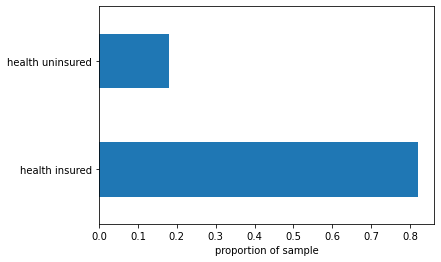

In [30]:
#plot overall percentage insured and uninsured
ax = data_all['FHICOVP'].value_counts(normalize=True).plot(kind='barh')
plt.xlabel('proportion of sample')
ax.set_yticks([0,1])
ax.set_yticklabels(['health insured','health uninsured'])

(0.0, 100.0)

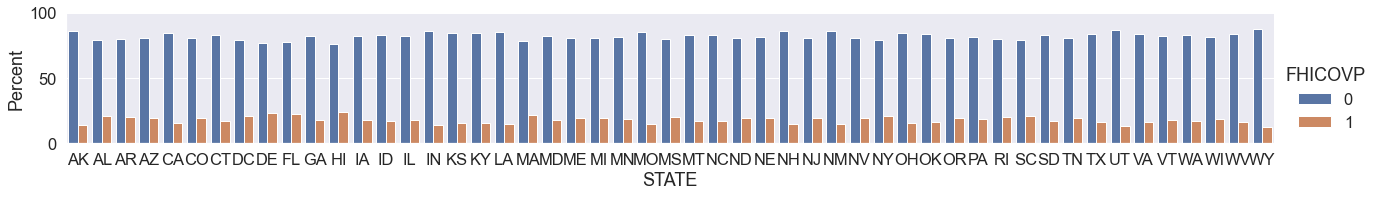

In [31]:
#plot percentage insured and uninsured by state
insdf  = data_all.groupby('STATE')['FHICOVP'].value_counts(normalize=True)
insdf  = insdf.mul(100).rename('Percent').reset_index()
sns.set(font_scale=1.5)
g = sns.catplot(x='STATE', y='Percent',hue='FHICOVP', kind='bar', data=insdf, height=3,aspect=6)
g.ax.set_ylim(0,100)